# Introduction

Welcome to the hands-on Colab notebook for TabPFN!
This code shows how to use TabPFN for large datasets using a random-forest preprocessing.

# Installation

Restart your runtime and rerun the *cell*, if Colab asks for it.

In [ ]:
# Install sklearn
!pip install scikit-learn==1.5.2

# Install TabPFN
!git clone https://github.com/PriorLabs/tabpfn
!pip install -e tabpfn

# TabPFN Community installs optional functionalities around the TabPFN model
# These include post-hoc ensembles, interpretability tools, and more
!git clone https://github.com/PriorLabs/tabpfn-extensions
!pip install -e tabpfn-extensions[post_hoc_ensembles,interpretability,hpo]

# Install Baselines
!pip install catboost xgboost

# Install example datasets
!pip install datasets

fatal: destination path 'tabpfn' already exists and is not an empty directory.
Obtaining file:///content/tabpfn
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tabpfn (pyproject.toml) ... done
  Created wheel for tabpfn: filename=tabpfn-2.0.9-0.editable-py3-none-any.whl size=14446 sha256=b855bb4eb0b7622298bdbe1f9f5d5eb1e7da3fd4b3d8d72482542e4c57c95eae
  Stored in directory: /tmp/pip-ephem-wheel-cache-8i0gurnu/wheels/b8/ff/db/916b5fcb3ef6ab5456ac93ea12c109010ccf8de25a042d9aa2
Successfully built tabpfn
  Attempting uninstall: tabpfn
    Found existing installation: tabpfn 2.0.9
    Uninstalling tabpfn-2.0.9:
      Successfully uninstalled tabpfn-2.0.9


fatal: destination path 'tabpfn-extensions' already exists and is not an empty directory.
Obtaining file:///content/tabpfn-extensions
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user
^C
^C
^C


**Now Restart the Runtime**

### In order to get the fastest predictions you need to enable GPUs for the notebook:
* Navigate to Edit→Notebook Settings
* select GPU from the Hardware Accelerator drop-down

# Example script

# Cross Validation



In [ ]:
import os

# Setup Imports
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer, load_diabetes, load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, Markdown, Latex

# Baseline Imports
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

import torch

from tabpfn import TabPFNClassifier, TabPFNRegressor
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier, AutoTabPFNRegressor

if not torch.cuda.is_available():
    raise SystemError('GPU device not found. For fast training, please enable GPU. See section above for instructions.')

## Predicting with TabPFN

For our first example, we will use the client to predict on [toy data from scikit-learn](https://scikit-learn.org/stable/datasets/toy_dataset.html).

### Classification

We now compare the classification performance of TabPFN, [XGBoost](https://xgboost.readthedocs.io/en/stable/), and [CatBoost](https://catboost.ai/) on the toy data from scikit-learn.

We measure classification performance using [ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html). These toy datasets are simple to solve, so the ROC AUC will be very high.

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import pandas as pd

#https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset
data = fetch_california_housing(as_frame=True)
df = data.frame
df['target'] = data.target

# Split (80% train, 20% test)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
test_data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,target
20046,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01,0.47700,0.47700
3024,2.5313,30.0,5.039384,1.193493,1565.0,2.679795,35.14,-119.46,0.45800,0.45800
15663,3.4801,52.0,3.977155,1.185877,1310.0,1.360332,37.80,-122.44,5.00001,5.00001
20484,5.7376,17.0,6.163636,1.020202,1705.0,3.444444,34.28,-118.72,2.18600,2.18600
9814,3.7250,34.0,5.492991,1.028037,1063.0,2.483645,36.62,-121.93,2.78000,2.78000
...,...,...,...,...,...,...,...,...,...,...
15362,4.6050,16.0,7.002212,1.066372,1351.0,2.988938,33.36,-117.22,2.63300,2.63300
16623,2.7266,28.0,6.131915,1.256738,1650.0,2.340426,35.36,-120.83,2.66800,2.66800
18086,9.2298,25.0,7.237676,0.947183,1585.0,2.790493,37.31,-122.05,5.00001,5.00001
2144,2.7850,36.0,5.289030,0.983122,1227.0,2.588608,36.77,-119.76,0.72300,0.72300


In [ ]:


X, y = df.drop(columns="target"), df.target


# Encode target labels to classes
le = LabelEncoder()
y = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



display(y)

array([3665, 3074, 3017, ...,  508,  432,  479])

In [ ]:
from tabpfn_extensions.rf_pfn import (
    RandomForestTabPFNClassifier,
    RandomForestTabPFNRegressor,
)

from tabpfn_extensions import TabPFNClassifier, TabPFNRegressor

# ----------------------------
# Classification - Strategy 1: Random Forest Preprocessing
# ----------------------------

clf_base = TabPFNClassifier(
    ignore_pretraining_limits=True,
    inference_config = {"SUBSAMPLE_SAMPLES": 10000} # Needs to be set low so that not OOM on fitting intermediate nodes
)

tabpfn_tree_clf = RandomForestTabPFNClassifier(
    tabpfn=clf_base,
    verbose=1,
    max_predict_time=60, # Will fit for one minute
    fit_nodes=True, # Wheather or not to fit intermediate nodes
    adaptive_tree=True, # Whather or not to validate if adding a leaf helps or not
  )

In [ ]:
# ----------------------------
# Classification - Strategy 2: Subsampled Ensemble using TabPFNClassifier
# ----------------------------
print("\n--- Classification: Strategy 1 (Subsampled Ensemble) ---")
tabpfn_subsample_clf = TabPFNClassifier(
    ignore_pretraining_limits=True,  # (bool) Allows the use of datasets larger than pretraining limits.
    n_estimators=32,                 # (int) Number of estimators for ensembling; improves accuracy with higher values.
    inference_config={
        "SUBSAMPLE_SAMPLES": 10000  # (int) Maximum number of samples per inference step to manage memory usage.
    },
)


--- Classification: Strategy 1 (Subsampled Ensemble) ---


In [ ]:
# Compare different machine learning models by training each one multiple times
# on different parts of the data and averaging their performance scores for a
# more reliable performance estimate

assert len(np.unique(y)) <= 10 # Is classification?

# Define models
models_class = [
    ('TabPFN RF', tabpfn_tree_clf),
    ('TabPFN Subsample', tabpfn_subsample_clf),
    ('XGBoost', XGBClassifier()),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
]

# Calculate scores
cv = KFold(random_state=42, n_splits=3, shuffle=True)
scoring = 'roc_auc_ovr' if len(np.unique(y)) > 2 else 'roc_auc'
scores_raw_class = {name: cross_val_score(model, X, y, cv=cv, scoring=scoring, verbose=1)
          for name, model in models_class}
scores_class = {name: scores_raw_class[name].mean()
          for name, model in models_class}

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.3s


Starting tree leaf validation train (24166, 8) valid (6042, 8)
Estimators: 1, Nodes per estimator: 33
Leaf: 0 Shape: (24166, 8) Shape test: 6042 / (6042, 8) N classes (Train Test) 2 2 /  2


/content/tabpfn/src/tabpfn/base.py:88: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-classifier.ckpt.
  model, _, config_ = load_model_criterion_config(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 24166 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 0 Averaging: -0.6931471805599454 Replacement: -0.3146091396577499
Leaf: 0 Score: -0.3146091396577499
Leaf: 1 Shape: (4961, 8) Shape test: 1272 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 1 Averaging: -0.3146092656485771 Replacement: -0.30525118185964384
Leaf: 1 Score: -0.30525118185964384
Leaf: 2 Shape: (2078, 8) Shape test: 536 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 2 Averaging: -0.30525124165032863 Replacement: -0.3026188537048708
Leaf: 2 Score: -0.3026188537048708
Leaf: 3 Shape: (1167, 8) Shape test: 291 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 3 Averaging: -0.30261888924218683 Replacement: -0.3015036840600222
Leaf: 3 Score: -0.3015036840600222
Leaf: 4 Shape: (911, 8) Shape test: 245 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 4 Averaging: -0.3015037122485813 Replacement: -0.30100139848263285
Leaf: 4 Score: -0.30100139848263285
Leaf: 5 Shape: (2883, 8) Shape test: 736 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 5 Averaging: -0.301001473096

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 30208 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 2 Shape: (2614, 8) Shape test: 1259 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 3 Shape: (1458, 8) Shape test: 719 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 4 Shape: (1156, 8) Shape test: 540 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 5 Shape: (3619, 8) Shape test: 1777 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 8 Shape: (2593, 8) Shape test: 1290 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 18 Shape: (1594, 8) Shape test: 807 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 20 Shape: (2066, 8) Shape test: 1012 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 22 Shape: (1360, 8) Shape test: 654 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 23 Shape: (5104, 8) Shape test: 2661 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 25 Shape: (1000, 8) Shape test: 534 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 27 Shape: (2260, 8) Shape test: 1195 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 31 Shape: (662, 8) Shape test: 326 / (15104, 8) N classes 

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 24166 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 0 Averaging: -0.6931471805599454 Replacement: -0.32749037413267973
Leaf: 0 Score: -0.32749037413267973
Leaf: 1 Tree 0 No train (6302) / test data 1580
Leaf: 2 Shape: (2589, 8) Shape test: 652 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 2 Averaging: -0.3274904530410985 Replacement: -0.324726320401078
Leaf: 2 Score: -0.324726320401078
Leaf: 3 Shape: (1090, 8) Shape test: 259 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 3 Averaging: -0.3247263474982496 Replacement: -0.32438125711358323
Leaf: 3 Score: -0.32438125711358323
Leaf: 4 Shape: (1499, 8) Shape test: 393 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 4 Averaging: -0.3243813090420776 Replacement: -0.32470434966038936
Leaf: 4 Score: -0.32438125711358323
Leaf: 5 Shape: (3713, 8) Shape test: 928 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 5 Averaging: -0.3243813055396702 Replacement: -0.3065741209824672
Leaf: 5 Score: -0.3065741209824672
Leaf: 6 Shape: (1060, 8) Shape test: 243 / (6042, 8) N classes (Train Tes

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 30208 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 2 Shape: (3241, 8) Shape test: 1594 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 3 Shape: (1349, 8) Shape test: 689 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 5 Shape: (4641, 8) Shape test: 2313 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 6 Shape: (1303, 8) Shape test: 631 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 7 Shape: (3338, 8) Shape test: 1682 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 14 Shape: (2872, 8) Shape test: 1472 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 15 Shape: (1737, 8) Shape test: 895 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 16 Shape: (1135, 8) Shape test: 577 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 19 Shape: (3890, 8) Shape test: 1998 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 20 Shape: (1219, 8) Shape test: 556 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 21 Shape: (3587, 8) Shape test: 1782 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 22 Shape: (1271, 8) Shape test: 591 / (15104, 8) N classes

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 24166 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 0 Averaging: -0.6931471805599454 Replacement: -0.3027277143017958
Leaf: 0 Score: -0.3027277143017958
Leaf: 1 Tree 0 No train (16831) / test data 4189
Leaf: 2 Tree 0 No train (12441) / test data 3138
Leaf: 3 Shape: (4278, 8) Shape test: 1043 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 3 Averaging: -0.302727824277379 Replacement: -0.29795683680374535
Leaf: 3 Score: -0.29795683680374535
Leaf: 4 Shape: (3987, 8) Shape test: 985 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 4 Averaging: -0.2979569281276753 Replacement: -0.2987236348304082
Leaf: 4 Score: -0.29795683680374535
Leaf: 5 Shape: (1296, 8) Shape test: 317 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 5 Averaging: -0.29795685429386454 Replacement: -0.2992323004208214
Leaf: 5 Score: -0.29795683680374535
Leaf: 6 Shape: (2691, 8) Shape test: 668 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 6 Averaging: -0.29795691063755614 Replacement: -0.29911922301334676
Leaf: 6 Score: -0.29795683680374535
Leaf: 7 Shape: (291

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 30208 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 9 Shape: (3021, 8) Shape test: 1549 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 13 Shape: (1594, 8) Shape test: 768 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 14 Shape: (5643, 8) Shape test: 2837 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 16 Shape: (3694, 8) Shape test: 1855 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 17 Shape: (2675, 8) Shape test: 1395 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 19 Shape: (2509, 8) Shape test: 1307 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 21 Shape: (1747, 8) Shape test: 904 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 23 Shape: (1169, 8) Shape test: 588 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 28 Shape: (2617, 8) Shape test: 1334 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 30 Shape: (1747, 8) Shape test: 812 / (15104, 8) N classes (Train Test) 2 /  2


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.7s


Starting tree leaf validation train (24166, 8) valid (6042, 8)
Estimators: 1, Nodes per estimator: 39
Leaf: 0 Shape: (24166, 8) Shape test: 6042 / (6042, 8) N classes (Train Test) 2 2 /  2


/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 24166 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 0 Averaging: -0.6931471805599454 Replacement: -0.30207582231468566
Leaf: 0 Score: -0.30207582231468566
Leaf: 1 Tree 0 No train (17136) / test data 4334
Leaf: 2 Tree 0 No train (12895) / test data 3284
Leaf: 3 Shape: (2547, 8) Shape test: 621 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 3 Averaging: -0.30207587624444837 Replacement: -0.2887227983840463
Leaf: 3 Score: -0.2887227983840463
Leaf: 4 Shape: (1051, 8) Shape test: 246 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 4 Averaging: -0.2887228332886018 Replacement: -0.2907086075748647
Leaf: 4 Score: -0.2887227983840463
Leaf: 5 Shape: (1496, 8) Shape test: 375 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 5 Averaging: -0.2887228247301328 Replacement: -0.28786078921427344
Leaf: 5 Score: -0.28786078921427344
Leaf: 6 Tree 0 No train (10348) / test data 2663
Leaf: 7 Shape: (3226, 8) Shape test: 817 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 7 Averaging: -0.2878608867648601 Replacement: -0.2748738342092728
Leaf: 7 

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 30208 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 3 Shape: (3168, 8) Shape test: 1577 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 5 Shape: (1871, 8) Shape test: 982 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 7 Shape: (4043, 8) Shape test: 1980 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 9 Shape: (2793, 8) Shape test: 1344 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 11 Shape: (1991, 8) Shape test: 964 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 12 Shape: (6977, 8) Shape test: 3555 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 14 Shape: (2567, 8) Shape test: 1311 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 22 Shape: (659, 8) Shape test: 294 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 25 Shape: (3587, 8) Shape test: 1801 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 26 Shape: (2645, 8) Shape test: 1332 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 31 Shape: (942, 8) Shape test: 469 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 35 Shape: (579, 8) Shape test: 287 / (15104, 8) N classes 

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 24166 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 0 Averaging: -0.6931471805599454 Replacement: -0.32521578611917895
Leaf: 0 Score: -0.32521578611917895
Leaf: 1 Tree 0 No train (6904) / test data 1725
Leaf: 2 Shape: (1395, 8) Shape test: 333 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 2 Averaging: -0.3252158136637764 Replacement: -0.3188196281302536
Leaf: 2 Score: -0.3188196281302536
Leaf: 3 Tree 0 No train (5509) / test data 1392
Leaf: 4 Shape: (4757, 8) Shape test: 1200 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 4 Averaging: -0.3188196932448142 Replacement: -0.2960746529682172
Leaf: 4 Score: -0.2960746529682172
Leaf: 5 Shape: (999, 8) Shape test: 261 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 5 Averaging: -0.2960746764715658 Replacement: -0.2984181225914321
Leaf: 5 Score: -0.2960746529682172
Leaf: 6 Shape: (3758, 8) Shape test: 939 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 6 Averaging: -0.2960747189878384 Replacement: -0.2968113117852933
Leaf: 6 Score: -0.2960746529682172
Leaf: 7 Shape: (1691, 8) Sh

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 30208 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 2 Shape: (1728, 8) Shape test: 809 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 7 Shape: (2113, 8) Shape test: 1074 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 8 Shape: (2584, 8) Shape test: 1283 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 9 Shape: (944, 8) Shape test: 501 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 11 Shape: (3007, 8) Shape test: 1531 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 12 Shape: (1768, 8) Shape test: 882 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 13 Shape: (1239, 8) Shape test: 649 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 15 Shape: (3746, 8) Shape test: 1845 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 17 Shape: (2430, 8) Shape test: 1197 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 18 Shape: (775, 8) Shape test: 382 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 22 Shape: (11624, 8) Shape test: 5741 / (15104, 8) N classes (Train Test) 2 /  2


/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 11624 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 23 Shape: (2357, 8) Shape test: 1215 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 24 Shape: (845, 8) Shape test: 489 / (15104, 8) N classes (Train Test) 2 /  2
Starting tree leaf validation train (24166, 8) valid (6042, 8)
Estimators: 1, Nodes per estimator: 29
Leaf: 0 Shape: (24166, 8) Shape test: 6042 / (6042, 8) N classes (Train Test) 2 2 /  2


/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 24166 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 0 Averaging: -0.6931471805599454 Replacement: -0.3054546186557708
Leaf: 0 Score: -0.3054546186557708
Leaf: 1 Tree 0 No train (5584) / test data 1356
Leaf: 2 Tree 0 No train (5359) / test data 1305
Leaf: 3 Shape: (1868, 8) Shape test: 479 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 3 Averaging: -0.3054546717718602 Replacement: -0.30169282985329887
Leaf: 3 Score: -0.30169282985329887
Leaf: 4 Shape: (1489, 8) Shape test: 390 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 4 Averaging: -0.3016928293840654 Replacement: -0.301889691755687
Leaf: 4 Score: -0.3016928293840654
Leaf: 5 Shape: (379, 8) Shape test: 89 / (6042, 8) N classes (Train Test) 2 1 /  2
Leaf: 5 Averaging: -0.3016928438890102 Replacement: -0.3016229539944612
Leaf: 5 Score: -0.3016229539944612
Leaf: 6 Shape: (3491, 8) Shape test: 826 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 6 Averaging: -0.3016230141204602 Replacement: -0.2879143687030885
Leaf: 6 Score: -0.2879143687030885
Leaf: 7 Shape: (1129, 8) Shape

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 30208 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 3 Shape: (2347, 8) Shape test: 1120 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 4 Shape: (1879, 8) Shape test: 900 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 5 Shape: (468, 8) Shape test: 220 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 6 Shape: (4317, 8) Shape test: 2184 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 8 Shape: (2939, 8) Shape test: 1437 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 9 Shape: (2876, 8) Shape test: 1408 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 11 Shape: (276, 8) Shape test: 149 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 15 Shape: (3101, 8) Shape test: 1513 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 17 Shape: (930, 8) Shape test: 465 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 19 Shape: (1432, 8) Shape test: 733 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 20 Shape: (9010, 8) Shape test: 4485 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 22 Shape: (446, 8) Shape test: 246 / (15104, 8) N classes (Tra

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 24166 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 0 Averaging: -0.6931471805599454 Replacement: -0.29961387119460536
Leaf: 0 Score: -0.29961387119460536
Leaf: 1 Shape: (4515, 8) Shape test: 1161 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 1 Averaging: -0.2996139837980717 Replacement: -0.2812428563756516
Leaf: 1 Score: -0.2812428563756516
Leaf: 2 Shape: (2498, 8) Shape test: 605 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 2 Averaging: -0.2812429035801303 Replacement: -0.2824446081891415
Leaf: 2 Score: -0.2812428563756516
Leaf: 3 Shape: (1519, 8) Shape test: 372 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 3 Averaging: -0.2812429130165115 Replacement: -0.2826203232629234
Leaf: 3 Score: -0.2812428563756516
Leaf: 4 Shape: (979, 8) Shape test: 233 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 4 Averaging: -0.2812428469392705 Replacement: -0.28177424906130766
Leaf: 4 Score: -0.2812428469392705
Leaf: 5 Shape: (2017, 8) Shape test: 556 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 5 Averaging: -0.281242835823610

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 30208 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 4 Shape: (1212, 8) Shape test: 632 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 5 Shape: (2573, 8) Shape test: 1338 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 8 Shape: (1548, 8) Shape test: 823 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 13 Shape: (3290, 8) Shape test: 1615 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 14 Shape: (3206, 8) Shape test: 1581 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 17 Shape: (3200, 8) Shape test: 1588 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 18 Shape: (11856, 8) Shape test: 5835 / (15104, 8) N classes (Train Test) 2 /  2


/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 11856 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 19 Shape: (3048, 8) Shape test: 1521 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 21 Shape: (738, 8) Shape test: 364 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 22 Shape: (2278, 8) Shape test: 1137 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 24 Shape: (3138, 8) Shape test: 1710 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 26 Shape: (2588, 8) Shape test: 1386 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 27 Shape: (1206, 8) Shape test: 616 / (15104, 8) N classes (Train Test) 2 /  2


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.8s


Starting tree leaf validation train (24166, 8) valid (6042, 8)
Estimators: 1, Nodes per estimator: 35
Leaf: 0 Shape: (24166, 8) Shape test: 6042 / (6042, 8) N classes (Train Test) 2 2 /  2


/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 24166 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 0 Averaging: -0.6931471805599454 Replacement: -0.30618630810865605
Leaf: 0 Score: -0.30618630810865605
Leaf: 1 Tree 0 No train (5994) / test data 1542
Leaf: 2 Shape: (1984, 8) Shape test: 520 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 2 Averaging: -0.30618634053393395 Replacement: -0.3055831744114965
Leaf: 2 Score: -0.3055831744114965
Leaf: 3 Shape: (1716, 8) Shape test: 449 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 3 Averaging: -0.30558318696170683 Replacement: -0.30501227928293373
Leaf: 3 Score: -0.30501227928293373
Leaf: 4 Tree 0 No train (10) / test data 3
Leaf: 5 Shape: (1706, 8) Shape test: 446 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 5 Averaging: -0.3050122957692237 Replacement: -0.30492008423759615
Leaf: 5 Score: -0.30492008423759615
Leaf: 6 Shape: (1577, 8) Shape test: 407 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 6 Averaging: -0.3049201024668716 Replacement: -0.30553689159372993
Leaf: 6 Score: -0.30492008423759615
Leaf: 7 Shape: (129, 8) 

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 30208 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 2 Shape: (2504, 8) Shape test: 1272 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 3 Shape: (2165, 8) Shape test: 1103 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 5 Shape: (2152, 8) Shape test: 1096 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 7 Shape: (168, 8) Shape test: 76 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 20 Shape: (2104, 8) Shape test: 1023 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 21 Shape: (6718, 8) Shape test: 3402 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 22 Shape: (4997, 8) Shape test: 2540 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 23 Shape: (4910, 8) Shape test: 2489 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 25 Shape: (2019, 8) Shape test: 944 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 27 Shape: (929, 8) Shape test: 408 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 32 Shape: (1740, 8) Shape test: 858 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 34 Shape: (1119, 8) Shape test: 558 / (15104, 8) N classes 

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 24166 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 0 Averaging: -0.6931471805599454 Replacement: -0.31105311687690335
Leaf: 0 Score: -0.31105311687690335
Leaf: 1 Tree 0 No train (20845) / test data 5212
Leaf: 2 Tree 0 No train (16689) / test data 4176
Leaf: 3 Shape: (3832, 8) Shape test: 952 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 3 Averaging: -0.31105320425808586 Replacement: -0.29336251707345434
Leaf: 3 Score: -0.29336251707345434
Leaf: 4 Shape: (1123, 8) Shape test: 275 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 4 Averaging: -0.29336255680594464 Replacement: -0.2953658672406688
Leaf: 4 Score: -0.29336251707345434
Leaf: 5 Shape: (2709, 8) Shape test: 677 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 5 Averaging: -0.29336257938780075 Replacement: -0.29369932332960835
Leaf: 5 Score: -0.29336251707345434
Leaf: 6 Tree 0 No train (60) / test data 15
Leaf: 7 Shape: (2649, 8) Shape test: 662 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 7 Averaging: -0.2933625770004886 Replacement: -0.29326436742977036
Leaf: 7

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 30208 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 3 Shape: (4784, 8) Shape test: 2376 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 7 Shape: (3311, 8) Shape test: 1660 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 13 Shape: (9526, 8) Shape test: 4729 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 14 Shape: (1206, 8) Shape test: 660 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 18 Shape: (3799, 8) Shape test: 1953 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 22 Shape: (4151, 8) Shape test: 1972 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 24 Shape: (3555, 8) Shape test: 1680 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 26 Shape: (2597, 8) Shape test: 1246 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 28 Shape: (2001, 8) Shape test: 957 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 30 Shape: (1369, 8) Shape test: 642 / (15104, 8) N classes (Train Test) 2 /  2
Starting tree leaf validation train (24166, 8) valid (6042, 8)
Estimators: 1, Nodes per estimator: 31
Leaf: 0 Shape: (24166, 8) Shape test: 6042 

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 24166 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 0 Averaging: -0.6931471805599454 Replacement: -0.3029454304446797
Leaf: 0 Score: -0.3029454304446797
Leaf: 1 Tree 0 No train (16824) / test data 4212
Leaf: 2 Tree 0 No train (15388) / test data 3847
Leaf: 3 Shape: (1718, 8) Shape test: 404 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 3 Averaging: -0.3029454832985293 Replacement: -0.3002638573636771
Leaf: 3 Score: -0.3002638573636771
Leaf: 4 Shape: (1673, 8) Shape test: 393 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 4 Averaging: -0.3002639050020751 Replacement: -0.30047697497502646
Leaf: 4 Score: -0.3002638573636771
Leaf: 5 Shape: (1650, 8) Shape test: 384 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 5 Averaging: -0.3002639038362047 Replacement: -0.30040559327045147
Leaf: 5 Score: -0.3002638573636771
Leaf: 6 Tree 0 No train (23) / test data 9
Leaf: 7 Tree 0 No train (45) / test data 11
Leaf: 8 Tree 0 No train (13670) / test data 3443
Leaf: 9 Shape: (3723, 8) Shape test: 948 / (6042, 8) N classes (Train Test) 2 2 /

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 30208 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 3 Shape: (2122, 8) Shape test: 1095 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 9 Shape: (4671, 8) Shape test: 2324 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 13 Shape: (3947, 8) Shape test: 2005 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 14 Shape: (8495, 8) Shape test: 4203 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 15 Shape: (1801, 8) Shape test: 959 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 17 Shape: (3371, 8) Shape test: 1667 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 19 Shape: (2742, 8) Shape test: 1366 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 20 Shape: (1962, 8) Shape test: 982 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 22 Shape: (1901, 8) Shape test: 954 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 23 Shape: (780, 8) Shape test: 384 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 27 Shape: (780, 8) Shape test: 379 / (15104, 8) N classes (Train Test) 2 /  2
Starting tree leaf validation train (24166, 8) valid (6042, 8)


/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 24166 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 0 Averaging: -0.6931471805599454 Replacement: -0.2920892647313807
Leaf: 0 Score: -0.2920892647313807
Leaf: 1 Tree 0 No train (6017) / test data 1519
Leaf: 2 Tree 0 No train (5220) / test data 1315
Leaf: 3 Shape: (4360, 8) Shape test: 1095 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 3 Averaging: -0.29208938114454164 Replacement: -0.29144183990930794
Leaf: 3 Score: -0.29144183990930794
Leaf: 4 Shape: (3954, 8) Shape test: 984 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 4 Averaging: -0.29144192385234646 Replacement: -0.29234963005126974
Leaf: 4 Score: -0.29144183990930794
Leaf: 5 Shape: (1068, 8) Shape test: 253 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 5 Averaging: -0.29144186274235045 Replacement: -0.2927073543949998
Leaf: 5 Score: -0.29144183990930794
Leaf: 6 Shape: (2886, 8) Shape test: 731 / (6042, 8) N classes (Train Test) 2 2 /  2
Leaf: 6 Averaging: -0.29144190101930395 Replacement: -0.2917788431809031
Leaf: 6 Score: -0.29144183990930794
Leaf: 7 Shape: (40

/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 30208 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Leaf: 7 Shape: (517, 8) Shape test: 258 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 9 Shape: (1001, 8) Shape test: 470 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 13 Shape: (3780, 8) Shape test: 1848 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 15 Shape: (3547, 8) Shape test: 1723 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 17 Shape: (9211, 8) Shape test: 4744 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 18 Shape: (1217, 8) Shape test: 574 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 24 Shape: (3422, 8) Shape test: 1638 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 26 Shape: (2657, 8) Shape test: 1269 / (15104, 8) N classes (Train Test) 2 /  2
Leaf: 28 Shape: (1450, 8) Shape test: 690 / (15104, 8) N classes (Train Test) 2 /  2


/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 30208 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 30208 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
/content/tabpfn/src/tabpfn/classifier.py:417: UserWarning: Number of samples 30208 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


Text(0.5, 1.0, 'Model Comparison - 5-fold Cross-validation')

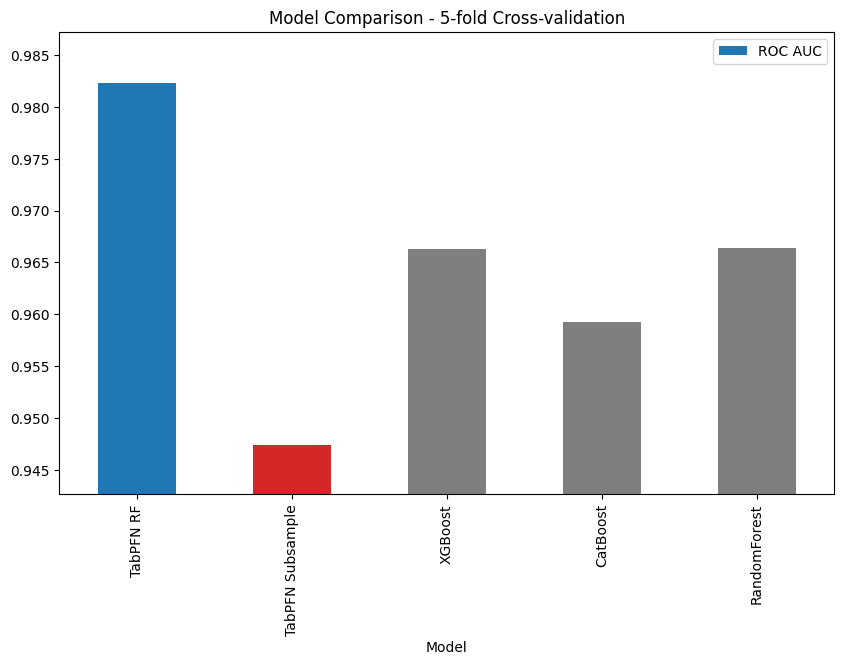

In [ ]:
# Plot results
df = pd.DataFrame(list(scores_class.items()), columns=['Model', 'ROC AUC'])
colors = ['tab:blue' if 'RF' in name else ('tab:red' if 'sample' in name else 'tab:gray') for (name, _) in models_class]
ax = df.plot(x='Model', y='ROC AUC', kind='bar', figsize=(10, 6), color=colors)
ax.set_ylim(df['ROC AUC'].min() * 0.995, min(1.0, df['ROC AUC'].max() * 1.005))
ax.set_title('Model Comparison - 5-fold Cross-validation')

### Regression

We now compare the regression performance of TabPFN, [XGBoost](https://xgboost.readthedocs.io/en/stable/), and [CatBoost](https://catboost.ai/) on the toy data from scikit-learn.

We measure regression performance using [Root Mean Squared Error](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.root_mean_squared_error.html).

In [ ]:


X, y = df.drop(columns="target"), df.target


# Encode target labels to classes
le = LabelEncoder()
y = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



display(y)

array([3665, 3074, 3017, ...,  508,  432,  479])

In [ ]:
from tabpfn_extensions.rf_pfn import (
    RandomForestTabPFNClassifier,
    RandomForestTabPFNRegressor,
)

from tabpfn_extensions import TabPFNClassifier, TabPFNRegressor

# ----------------------------
# Classification - Strategy 2: Random Forest Preprocessing
# ----------------------------

reg_base = TabPFNRegressor(
    ignore_pretraining_limits=True,
    inference_config = {"SUBSAMPLE_SAMPLES": 10000} # Needs to be set low so that not OOM on fitting intermediate nodes
)

tabpfn_tree_reg = RandomForestTabPFNRegressor(
    tabpfn=reg_base,
    verbose=1,
    max_predict_time=60, # Will fit for one minute
    fit_nodes=True, # Wheather or not to fit intermediate nodes
    adaptive_tree=True, # Whather or not to validate if adding a leaf helps or not
  )

In [ ]:
# ----------------------------
# Regression - Strategy 2: Subsampled Ensemble using TabPFNRegressor
# ----------------------------
print("\n--- Regression: Strategy 1 (Subsampled Ensemble) ---")
tabpfn_subsample_reg = TabPFNRegressor(
    ignore_pretraining_limits=True,  # (bool) Enables handling datasets beyond pretraining constraints.
    n_estimators=32,                 # (int) Number of estimators in the ensemble for robustness.
    inference_config={
        "SUBSAMPLE_SAMPLES": 10000  # (int) Controls sample subsampling per inference to avoid OOM errors.
    },
)


--- Regression: Strategy 1 (Subsampled Ensemble) ---


In [ ]:
assert len(np.unique(y)) >= 10 # Is regression?

# Compare different machine learning models by training each one multiple times
# on different parts of the data and averaging their performance scores for a
# more reliable performance estimate

# Define models
models_reg = [
    ('TabPFN RF', tabpfn_tree_reg),
    ('TabPFN Subsample', tabpfn_subsample_reg),
    ('RandomForest', RandomForestRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('CatBoost', CatBoostRegressor(random_state=42, verbose=0))
]

# Calculate scores
scoring = 'r2'
cv = KFold(random_state=0, n_splits=3, shuffle=True)
scores_raw_reg = {name: cross_val_score(model, X, y, cv=cv, scoring=scoring, verbose=2)
          for name, model in models_reg}
scores_reg = {name: scores_raw_reg[name].mean()
          for name, model in models_reg}

/content/tabpfn/src/tabpfn/base.py:101: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-regressor.ckpt.
  model, bardist, config_ = load_model_criterion_config(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

/content/tabpfn/src/tabpfn/regressor.py:450: UserWarning: Number of samples 11008 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
/content/tabpfn/src/tabpfn/regressor.py:450: UserWarning: Number of samples 13760 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


[CV] END .................................................... total time= 2.6min


/content/tabpfn/src/tabpfn/regressor.py:450: UserWarning: Number of samples 11008 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:3416: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:3416: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:3416: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:3416: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/content/tabpfn/src/tabpf

[CV] END .................................................... total time= 2.4min


/content/tabpfn/src/tabpfn/regressor.py:450: UserWarning: Number of samples 11008 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
/content/tabpfn/src/tabpfn/regressor.py:450: UserWarning: Number of samples 13760 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


[CV] END .................................................... total time= 2.2min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.2min finished
/content/tabpfn/src/tabpfn/regressor.py:450: UserWarning: Number of samples 13760 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


[CV] END .................................................... total time= 1.4min


/content/tabpfn/src/tabpfn/regressor.py:450: UserWarning: Number of samples 13760 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


[CV] END .................................................... total time= 1.4min


/content/tabpfn/src/tabpfn/regressor.py:450: UserWarning: Number of samples 13760 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


[CV] END .................................................... total time= 1.4min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.1min finished


[CV] END .................................................... total time=   9.3s
[CV] END .................................................... total time=   9.8s
[CV] END .................................................... total time=  10.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.3s finished


[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s finished


[CV] END .................................................... total time=   3.9s
[CV] END .................................................... total time=   5.2s
[CV] END .................................................... total time=   3.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.9s finished


Text(0.5, 1.0, 'Model Comparison - 5-fold Cross-validation \n (Variance Explained)')

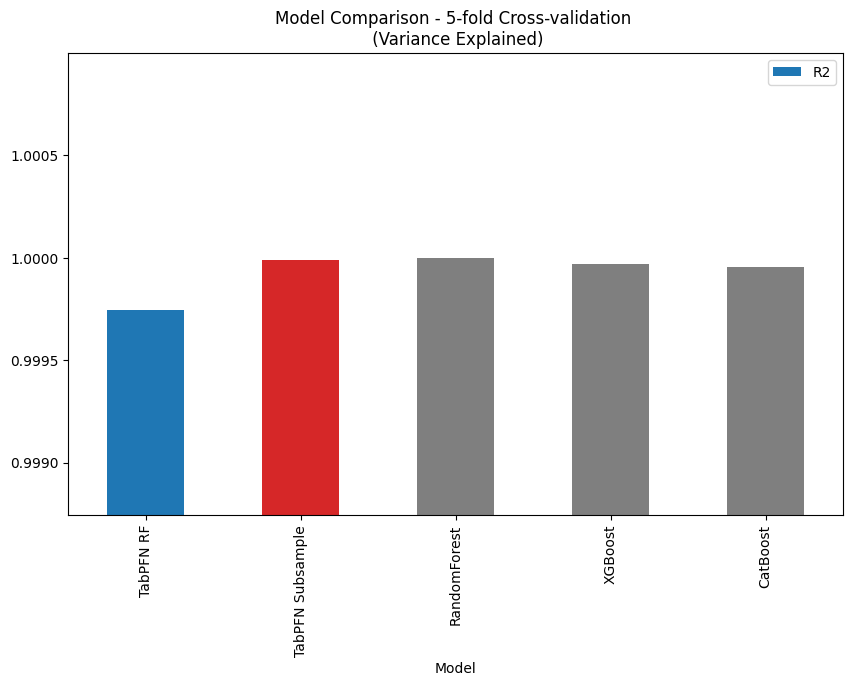

In [ ]:
# Plot results
colors = ['tab:blue' if 'RF' in name else ('tab:red' if 'sample' in name else 'tab:gray') for (name, _) in models_reg]
df = pd.DataFrame(list(scores_reg.items()), columns=['Model', 'R2'])
ax = df.plot(x='Model', y='R2', kind='bar', figsize=(10, 6), color=colors)
ax.set_ylim(df['R2'].min() * 0.999, df['R2'].max() * 1.001)
ax.set_title('Model Comparison - 5-fold Cross-validation \n (Variance Explained)')